In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time

#import mdtraj as md
import nglview
import openmm
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper
from openff.units import unit
from pandas import read_csv
import espaloma_charge as espcharge
from espaloma_charge.openff_wrapper import EspalomaChargeToolkitWrapper

from openff.interchange import Interchange
from openff.interchange.components._packmol import UNIT_CUBE, pack_box


from functools import reduce
from statistics import mean
from rdkit.Chem.Descriptors import ExactMolWt
from openff.interchange import Interchange
from openff.interchange.components._packmol import UNIT_CUBE, pack_box

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('../Outputs/')

from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H_%M_%S")

dir_name = './Ensemble/' + 'PLGA' + '_' + str(now)
os.makedirs(dir_name,  exist_ok=True)
os.chdir(dir_name)

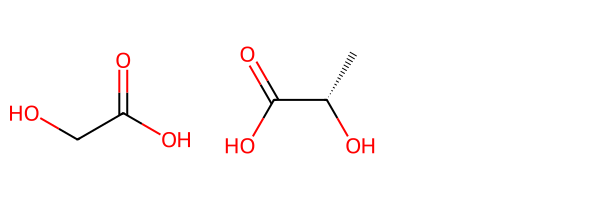

In [3]:
#Import monomers
monomer_smiles = ['OC(=O)CO', 'C[C@@H](C(=O)[OH])O']
glycolic = Chem.MolFromSmiles(monomer_smiles[0])
lactate = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic,lactate])

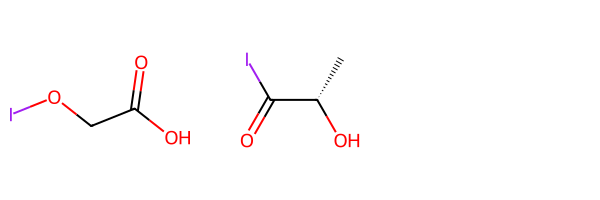

In [4]:
#Import monomers - Iodinated
monomer_smiles = ['OC(=O)COI', 'C[C@H](O)C(=O)I']
glycolic_I = Chem.MolFromSmiles(monomer_smiles[0])
lactate_I = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic_I,lactate_I])

In [5]:
def build_PLGA_linear(reaction, sequence):
    '''Build a polymer of specified sequence monomers and return the sanitized polymer, specify monomer joining scheme using reaction SMARTS
    takes a list of up to 2 monomers to create a co-polymer, monomer input is a RDkit.Chem Mol object, not a SMILES string'''
    polymer = Chem.MolFromSmiles('C[C@H](O)C(=O)I') if sequence[0]=='L' else Chem.MolFromSmiles('OC(=O)COI')
    LA_count=0 if sequence[0]=='G' else 1
    GA_count=0 if sequence[0]=='L' else 1
    for i in range(len(sequence)-1):
        if sequence[i+1] == 'L':
            polymer = gen_rxn.RunReactants((polymer, lactate))[0][0]
            Chem.SanitizeMol(polymer)
            LA_count+=1
        
        elif sequence[i+1] == 'G':
            polymer = gen_rxn.RunReactants((polymer, glycolic))[0][0]
            Chem.SanitizeMol(polymer)
            GA_count+=1
    LA_ratio = round((LA_count/len(sequence))*100,2)
    GA_ratio = round((GA_count/len(sequence))*100,2)
    polymer = Chem.ReplaceSubstructs(polymer, Chem.MolFromSmarts('[I]'), Chem.MolFromSmarts('[O]'))[0]
    Chem.SanitizeMol(polymer)
    return polymer, LA_ratio, GA_ratio

In [6]:
#Define reaction
gen_rxn = AllChem.ReactionFromSmarts('[C:1][HO:2].[HO:3][C:4]>>[C:1][O:2][C:4].[O:3]')
sequence = 'LLLGGGLL'
#Build polymer
chain, LA_ratio, GA_ratio = build_PLGA_linear(gen_rxn, sequence)

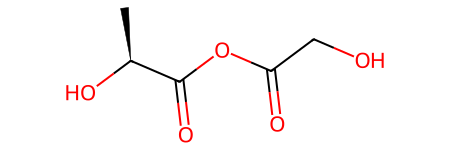

In [7]:
i_rxn = AllChem.ReactionFromSmarts('[O:1][I:2].[I:3][*:4]>>[O:1][*:4].[I:2][I:3]')
gen_rxn.RunReactants((glycolic, lactate))[0][0]

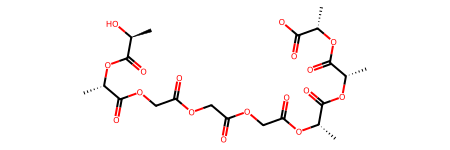

In [8]:
chain

In [9]:
openff_chain = Molecule.from_rdkit(chain)
openff_chain.generate_conformers()
openff_chain

NGLWidget(max_frame=9)

In [10]:
def print_polymer_charges(polymer, charge_scheme):
    '''return either AM1_BCC or espaloma charges for a polymer chain'''
    if charge_scheme == 'AM1_BCC':
        openff_chain = Molecule.from_rdkit(polymer)
        openff_polymer = openff_chain.generate_conformers()
        openff_polymer.assign_partial_charges("am1bcc")
        return openff_polymer.partial_charges
    elif charge_scheme == 'espaloma':
        chain_h = Chem.AddHs(polymer)
        return espcharge.charge(chain_h)
    else:
        raise AttributeError("This function takes either 'AM1_BCC' or 'espaloma' as charge_scheme input")

In [11]:
def assign_polymer_charges(polymer, charge_scheme):
    '''assign either AM1_BCC or espaloma charges to a polymer chain'''
    if charge_scheme == 'AM1_BCC':
        openff_chain = Molecule.from_rdkit(polymer)
        openff_polymer = openff_chain.generate_conformers()
        openff_polymer.assign_partial_charges("am1bcc")
    elif charge_scheme == 'espaloma':
        chain_h = Chem.AddHs(polymer)
    else:
        raise AttributeError("This function takes either 'AM1_BCC' or 'espaloma' as charge_scheme input")

In [12]:
print_polymer_charges(chain, 'espaloma')

array([ 9.4906718e-02, -4.7945428e-01,  7.5099421e-01,  7.5432169e-01,
       -1.3434556e-01, -4.6638623e-01, -5.5471528e-01, -7.3665474e-04,
        7.7763146e-01, -4.7590801e-01, -5.7317364e-01, -7.5516291e-06,
        7.7763146e-01, -4.7590801e-01, -5.7317364e-01, -6.5626577e-05,
        7.7703476e-01, -4.9674359e-01, -5.8333939e-01,  9.3759462e-02,
        7.5462633e-01, -1.3434556e-01, -4.8796496e-01, -5.6765550e-01,
        9.2810676e-02,  7.5462633e-01, -1.3434556e-01, -4.8532915e-01,
       -5.6765550e-01,  8.9948185e-02, -1.3111779e-01,  8.0123723e-01,
       -5.0907922e-01,  4.5017634e-02, -5.2901649e-01, -1.6377194e-01,
       -6.9591218e-01, -6.5544105e-01,  1.1340310e-01,  7.8578085e-02,
        7.8578085e-02,  7.8578085e-02,  1.2387785e-01,  1.2387785e-01,
        1.2387785e-01,  1.2387785e-01,  1.2387785e-01,  1.2387785e-01,
        1.1340310e-01,  7.8578085e-02,  7.8578085e-02,  7.8578085e-02,
        1.1340310e-01,  7.8578085e-02,  7.8578085e-02,  7.8578085e-02,
      

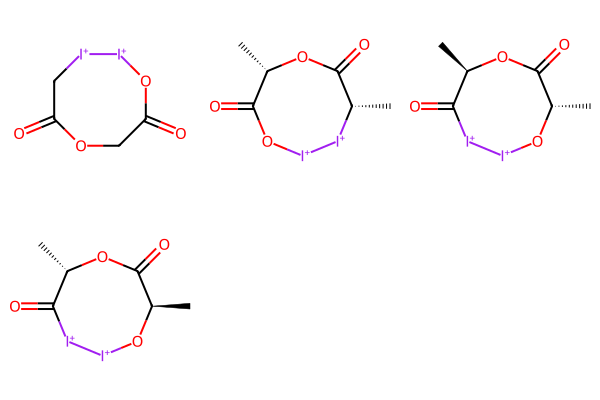

In [13]:
#Ring opening - Iodinated monomers
ring_smiles = ['O1C(=O)C[I+][I+]OC(=O)C1', 'C[C@@H]1[I+][I+]OC(=O)[C@H](C)OC1=O', 'C[C@@H]1O[I+][I+]C(=O)[C@@H](C)OC1=O', 'C[C@H]1O[I+][I+]C(=O)[C@H](C)OC1=O'] 
GG_i = Chem.MolFromSmiles(ring_smiles[0])
LL_1 = Chem.MolFromSmiles(ring_smiles[1])
LL_2 = Chem.MolFromSmiles(ring_smiles[2])
LL_3 = Chem.MolFromSmiles(ring_smiles[3])

Chem.Draw.MolsToGridImage([GG_i,LL_1, LL_2, LL_3])

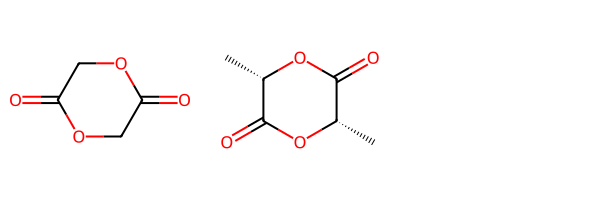

In [14]:
ring_smiles = ['O1C(=O)COC(=O)C1', 'C[C@@H]1OC(=O)[C@H](C)OC1=O'] 
GG = Chem.MolFromSmiles(ring_smiles[0])
LL = Chem.MolFromSmiles(ring_smiles[1])
Chem.Draw.MolsToGridImage([GG,LL])

In [15]:
Chem.Draw.MolToFile(LL, filename='LL.png')

In [16]:
i_rxn = AllChem.ReactionFromSmarts('[I:1][O:2].[I:3][C:4]>>[C:4][O:2].[I:3][I:1]') 
gen_rxn = AllChem.ReactionFromSmarts('[C:1][HO:2].[O:3][C:4]>>[C:1][O:2][C:4].[O:3]')

In [17]:
def build_PLGA_ring(reaction, sequence, terminal='hydroxyl'):
    '''Build a PLGA co-polymer of specified sequence and return the sanitized polymer, specify monomer joining scheme using reaction SMARTS
    takes a list of up to 2 monomers to create a co-polymer.
    This function takes the cyclic esters lactide and glycolide as constituent monomers
    Inputs:
    reaction = Reaction SMARTS rdkit chemical reaction object specifying the joining of 2 iodinated compounds into an ester
    sequence = string with sequence (L for Lactide, G for glycolic acid). For this function, sequence must be assembled as blocks of 2 monomers
        e.g. LLGGLLGG
    monomer input is a RDkit.Chem Mol.object, not a SMILES string and must contain I-I bridging the point of esterification
    Outputs:
    PLGA macromolecule as RDkit.Chem.Mol
    Lactide ratio %
    Glycolide ratio %
    '''
    polymer = Chem.MolFromSmiles('C[C@H](O)C(=O)O[C@H](C)C(=O)O[I+]') if sequence[0:2]=='LL' else Chem.MolFromSmiles('[I+]OC(=O)COC(=O)CO')
    LA_count=0 if sequence[0:2]=='GG' else 2
    GA_count=0 if sequence[0:2]=='LL' else 2
    for i in range(0, len(sequence)-1,2):
        if sequence[i+2:i+4] == 'LL':
            polymer = i_rxn.RunReactants((polymer, LL_1))[0][0]
            Chem.SanitizeMol(polymer)
            LA_count+=2
        
        elif sequence[i+2:i+4] == 'GG':
            polymer = i_rxn.RunReactants((polymer, GG_i))[0][0]
            Chem.SanitizeMol(polymer)
            GA_count+=2

        elif sequence[i+2:i+4] == 'GL' or sequence[i+2:i+4] == 'LG':
            raise AttributeError("Check sequence. Input format is LLGG (blocks of dimers) and sequence entered is "+ sequence)
            
    
    LA_ratio = round((LA_count/len(sequence))*100,2)
    GA_ratio = round((GA_count/len(sequence))*100,2)
    if terminal == 'hydroxyl':
        polymer = Chem.ReplaceSubstructs(polymer, Chem.MolFromSmarts('[OH]'), Chem.MolFromSmiles('O'))[0]
        Chem.AddHs(polymer)
    elif terminal == 'carboxyl':
        polymer = Chem.ReplaceSubstructs(polymer, Chem.MolFromSmarts('[OH]'), Chem.MolFromSmiles('OC(=O)[OH]'))[0]
    elif terminal == 'ester':
        polymer = Chem.ReplaceSubstructs(polymer, Chem.MolFromSmarts('[OH]'), Chem.MolFromSmiles('OC'))[0]
    else:
        raise ValueError("terminals accepts one of 3 arguments - hydroxyl, carboxyl or ester")
    polymer = Chem.ReplaceSubstructs(polymer, Chem.MolFromSmarts('O[I]'), Chem.MolFromSmarts('[O]'))[0]
    Chem.SanitizeMol(polymer)
    return polymer, LA_ratio, GA_ratio

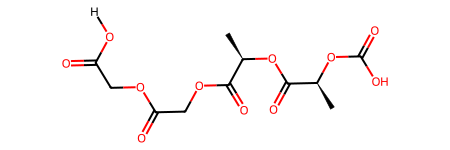

In [18]:
sequence = 'LLGG'
polymer = build_PLGA_ring(gen_rxn, sequence, 'carboxyl')[0]
Chem.Draw.MolToFile(polymer, 'carboxy_term.png', size=(500, 500))
polymer

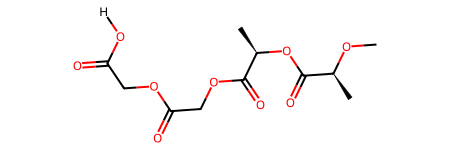

In [19]:
sequence = 'LLGG'
polymer = build_PLGA_ring(gen_rxn, sequence, 'ester')[0]
Chem.Draw.MolToFile(polymer, 'ester_term.png', size=(500, 500))
polymer

In [20]:
Chem.Draw.MolToFile(polymer, filename='GGLL.png', size=(600, 600))

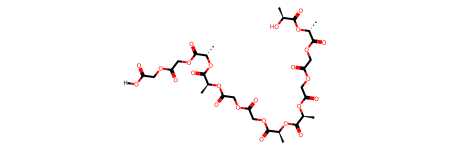

In [21]:
sequence = 'LLGGLLGGLLGG'
polymer = build_PLGA_ring(gen_rxn, sequence)[0]
polymer

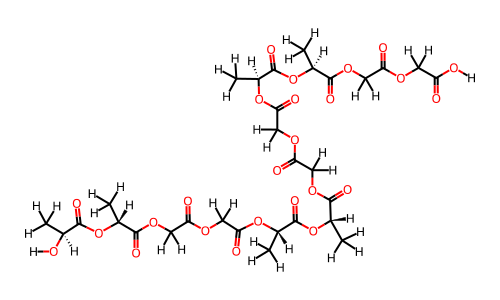

In [22]:
from espaloma_charge.openff_wrapper import EspalomaChargeToolkitWrapper
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper
openff_chain = Molecule.from_rdkit(polymer)
#Generate conformers using OpenFF toolkit wrapper
object = RDKitToolkitWrapper()
toolkit_registry = EspalomaChargeToolkitWrapper()
openff_chain.assign_partial_charges('espaloma-am1bcc', toolkit_registry=toolkit_registry)
openff_chain

In [23]:
def PDI(chains):
    #chains_rdkit = [Molecule.to_rdkit(chain) for chain in chains]
    mw_list = [ExactMolWt(chain) for chain in chains]  #_rdkit]
    #Mn = round(mean(mw_list),2)
    
    list = [round(mass) for mass in mw_list]
    Mi = set(list)
    NiMi = []
    for i in Mi:
        Ni = list.count(i)
        NiMi.append(i*Ni)
    sigNiMi = sum(NiMi)
    Mn = sigNiMi/len(mw_list)
    wf = [z/sigNiMi for z in NiMi]
    WiMi = [wf[n]*NiMi[n] for n in range(len(wf))]
    Mw = sum(WiMi)
    PDI = Mw/Mn
    return PDI, Mn, Mw

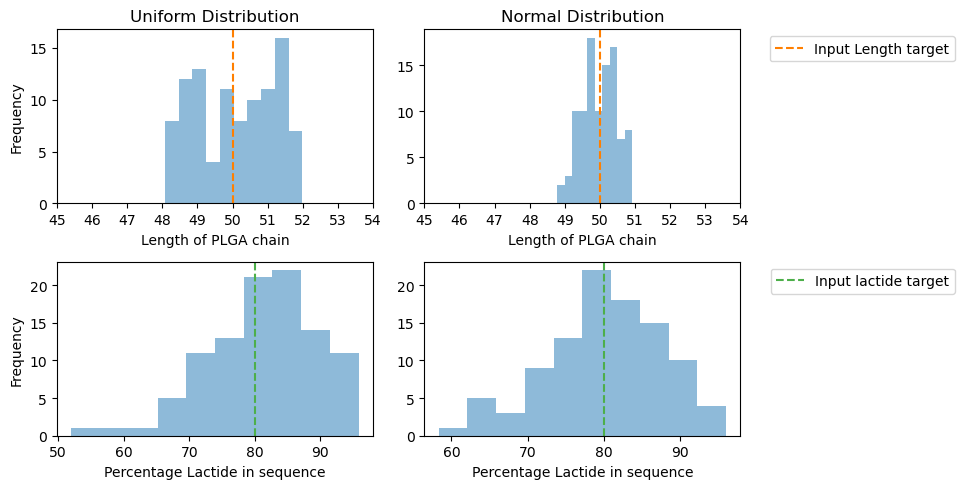

PDI_uniform =  (7.922085100481098, 3415.48, 27057.72321899118)
PDI_normal =  (7.582264930275187, 3415.12, 25894.344608681396)


In [24]:
# Effect of a normal distribution
perc_lactide_target, length_target, num_chains = 80, 50, 100# specify input parameters

#Generate lengths and sequences without a normal distribution applied
lengths_1 = []
lac_1 = []
chains_1 = []
for i in range(num_chains):
    length_actual = np.random.uniform(int(round(length_target*0.95)),int(round(length_target*1.05)))
    lengths_1.append(length_actual)
    sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
    actual_lac = sequence.count('L')
    lac_1.append((actual_lac/len(sequence)*100))
    chains_1.append(build_PLGA_ring(gen_rxn, sequence, 'hydroxyl')[0])
    PDI_1 = PDI(chains_1)
    

#Generate lengths and sequences with a normal distribution applied
lengths_2 = []
lac_2 = []
mw_list2 = []
chains_2 = []
for i in range(num_chains):
    length_actual = np.random.normal(length_target, 0.5)
    lengths_2.append(length_actual)
    sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
    actual_lac = sequence.count('L')
    lac_2.append((actual_lac/len(sequence)*100))
    chains_2.append(build_PLGA_ring(gen_rxn, sequence, 'hydroxyl')[0])
    PDI_2 = PDI(chains_2)

#Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].hist(lengths_1, rwidth=1, alpha=0.5)
axs[0,0].set_xticks(range(int(round(length_target*0.9)),int(round(length_target*1.1))))
axs[0,0].set_xlabel('Length of PLGA chain')
axs[0,0].set_ylabel('Frequency')
axs[0,0].axvline(length_target, color='#ff7f00', linestyle='--', label='Input Length target')
axs[0,0].set_title('Uniform Distribution')

axs[0,1].hist(lengths_2, rwidth=1, alpha=0.5)
axs[0,1].set_xticks(range(int(round(length_target*0.9)),int(round(length_target*1.1))))
axs[0,1].set_xlabel('Length of PLGA chain')
axs[0,1].axvline(length_target, color='#ff7f00', linestyle='--', label='Input Length target')
axs[0,1].set_title('Normal Distribution')
axs[0,1].legend(bbox_to_anchor=(1.7, 1.0))

axs[1,0].hist(lac_1, alpha=0.5)
axs[1,0].set_xlabel('Percentage Lactide in sequence')
axs[1,0].set_ylabel('Frequency')
axs[1,0].axvline(perc_lactide_target, color='#4daf4a', linestyle='--', label='Input lactide target')

axs[1,1].hist(lac_2, alpha=0.5)
axs[1,1].set_xlabel('Percentage Lactide in sequence')
axs[1,1].axvline(perc_lactide_target, color='#4daf4a', linestyle='--', label='Input lactide target')

plt.legend(bbox_to_anchor=(1.7, 1.0))
plt.tight_layout()
plt.show()

#Export plot as PNG image
fig.savefig('chain_length_lac_distribution.png', dpi=500)

print('PDI_uniform = ', PDI_1)
print('PDI_normal = ', PDI_2)

In [25]:
plt.legend?

Signature: plt.legend(*args, **kwargs) -> 'Legend'
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

.. note::
    Specific artists can be excluded from the automatic legend element
    selection by using a label starting with an underscore, "_".
    A string starting with an underscore is the default label for a

In [26]:
#Normal distribution only
import seaborn as sns
sns.set_context('poster')
# Effect of a normal distribution
perc_lactide_target, length_target, num_chains = 80, 50, 10000000 # specify input parameters

#Generate lengths and sequences with a normal distribution applied
count = 0
lengths_2 = []
lac_2 = []
for i in range(num_chains):
    length_actual = np.random.normal(length_target, 0.5)
    lengths_2.append(length_actual)
    sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
    actual_lac = sequence.count('L')
    lac_2.append((actual_lac/len(sequence)*100))
    count+=1
    if count %10000 ==0:
        print(count)



10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

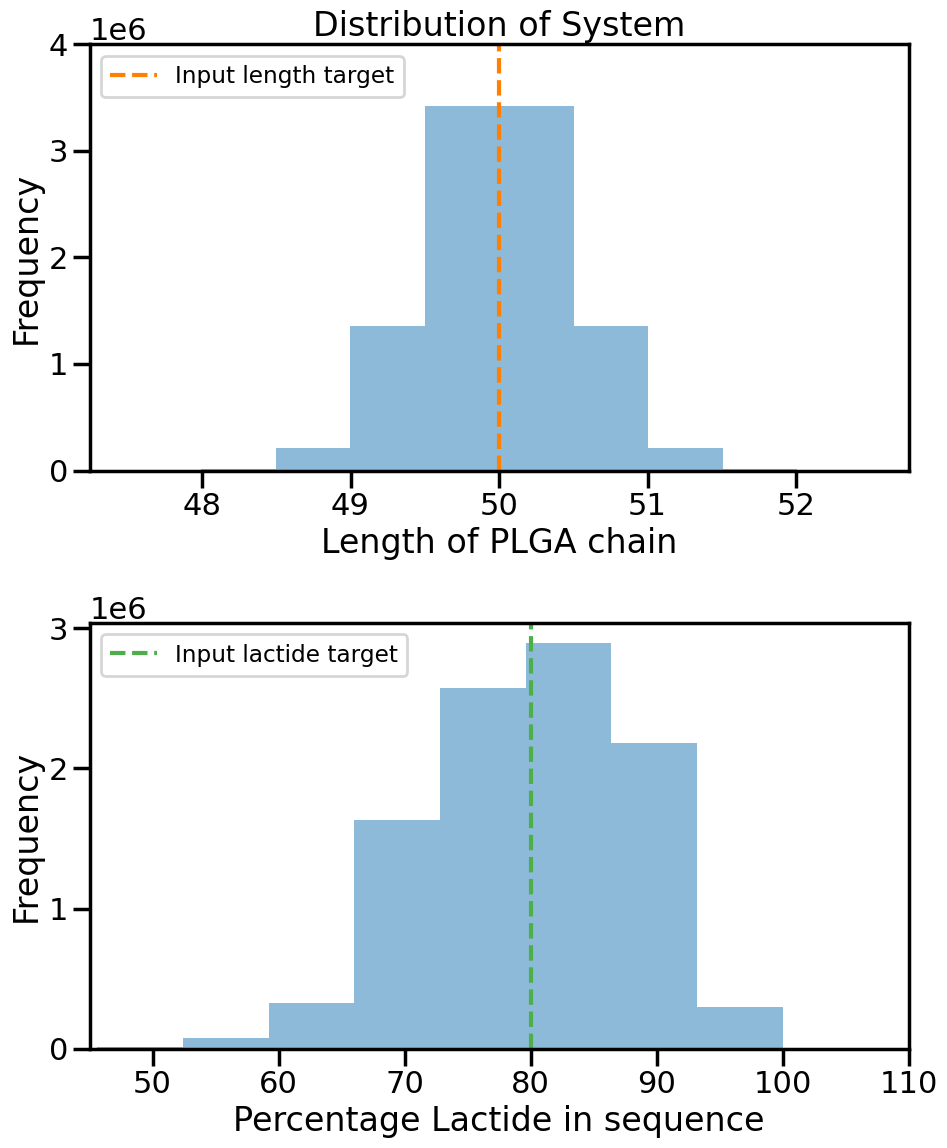

In [27]:
#Plot
fig, axs = plt.subplots(2, figsize=(10, 12))
axs[0].hist(lengths_2, rwidth=1, alpha=0.5)
axs[0].set_xlabel('Length of PLGA chain')
axs[0].set_ylabel('Frequency')
axs[0].axvline(length_target, color='#ff7f00', linestyle='--', label='Input length target')
axs[0].set_title('Distribution of System')
axs[0].legend(loc='upper left', fontsize='x-small')
axs[0].set_ylim(0,4000000)

axs[1].hist(lac_2, alpha=0.5)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Percentage Lactide in sequence')
axs[1].axvline(perc_lactide_target, color='#4daf4a', linestyle='--', label='Input lactide target')
axs[1].legend(loc='upper left',  fontsize='x-small')
axs[1].set_xlim(45,110)
plt.tight_layout()
plt.show()

#Export plot as PNG image
fig.savefig('chain_length_lac_distribution_poster.png', dpi=500)

In [28]:
def blockiness_calc(sequence):  
    if 'G' in sequence and 'L' in sequence:
        LG = sequence.count('LG')
        GG = sequence.count('GG')
        GL = sequence.count('GL')
        LL = sequence.count('LL')
        if 'GL' in sequence:
            blockiness = GG/GL
        else:
            blockiness = GG/LG
        
        block_list_G = [x for x in sequence.split('L') if x!='']
        block_length_G = mean([len(b) for b in block_list_G])
        
        block_list_L = [x for x in sequence.split('G') if x!='']
        block_length_L = mean([len(b) for b in block_list_L])
        return blockiness, block_length_G, block_length_L

    else:
        return 'Molecule is not a co-polymer, no blockiness calculation performed'
#blockiness_calc(x.sequence)

In [29]:
reaction = [0, 80]
perc_lactide_target = 80
blockiness_target = 1
sequence = 'LGLGLGGGGGGGLGGGGGGGGGGGGLGLGGGGGGLGLGLGLGGGGGLGLGLGLGGGGGLGGGGLLLLLGLGLGLGLGLGLGGGG'
def spec(reaction, sequence):
    return reaction[1] > perc_lactide_target*0.95 and reaction[1] < perc_lactide_target*1.05 and blockiness_calc(sequence)[0]>blockiness_target*0.9 and blockiness_calc(sequence)[0]<blockiness_target*1.1


spec(reaction, sequence)


True

In [30]:
#Class object for polymer system
from functools import reduce
from statistics import mean
from rdkit.Chem.Descriptors import ExactMolWt
from openff.interchange import Interchange
from openff.interchange.components._packmol import UNIT_CUBE, pack_box

class PLGA_system:
    '''A poly-lactide-(co)-glycolide polymer chain system class'''
    gen_rxn = AllChem.ReactionFromSmarts('[C:1][HO:2].[HO:3][C:4]>>[C:1][O:2][C:4].[O:3]')
    def __init__(self, perc_lactide_target, length_target, blockiness_target, terminals, num_chains): #Terminals will specify the end groups of the polymer (WIP)
        self.lactide_target = perc_lactide_target
        self.length_target = length_target
        self.blockiness_target = blockiness_target
        self.terminals = terminals
        def spec(sequence, blockiness): #Define limits of lactide percentage and blockiness from input
            actual_lac = (sequence.count('L')/len(sequence))*100
            return actual_lac > perc_lactide_target*0.95 and actual_lac < perc_lactide_target*1.05 and blockiness>blockiness_target*0.95 and blockiness<blockiness_target*1.05
        chains = []
        perc_lactide_actual = []
        out_of_spec = 0
        chains_rdkit = []
        lengths = []
        blockiness_list = []
        GBL = []
        LBL = []
        #First round of building
        for x in range(num_chains):
            length_actual = np.random.normal(length_target, 0.5)
            sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
            blockiness = blockiness_calc(sequence)[0]
            if spec(sequence, blockiness)==True:
                reaction = build_PLGA_ring(gen_rxn, sequence, terminals)
                lengths.append(int(length_actual))
                chains_rdkit.append(reaction[0])
                chain = Molecule.from_rdkit(reaction[0])
                chains.append(chain)
                perc_lactide_actual.append(reaction[1])
                blockiness_list.append(blockiness)
                GBL.append(blockiness_calc(sequence)[1])
                LBL.append(blockiness_calc(sequence)[2])
            else:
                out_of_spec +=1
        #Second round of building
        while out_of_spec >0:
            length_actual = np.random.normal(length_target, 0.5)
            sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
            blockiness = blockiness_calc(sequence)[0]
            if spec(sequence, blockiness)==True:
                reaction = build_PLGA_ring(gen_rxn, sequence, terminals)
                lengths.append(int(length_actual))
                chains_rdkit.append(reaction[0])
                chain = Molecule.from_rdkit(reaction[0])
                chains.append(chain)
                perc_lactide_actual.append(reaction[1])
                blockiness_list.append(blockiness)
                GBL.append(blockiness_calc(sequence)[1])
                LBL.append(blockiness_calc(sequence)[2])
                out_of_spec-=1
        self.sequence = sequence
        self.chains = chains
        self.chain_rdkit = chains_rdkit
        self.mol_weight_average = round(mean([ExactMolWt(c) for c in chains_rdkit]),2)
        self.PDI, self.Mn, self.Mw = PDI(chains_rdkit)
        self.num_chains = len(chains)
        self.perc_lactide_actual = perc_lactide_actual
        self.lactide_actual = mean(perc_lactide_actual)
        self.length_average = mean(lengths)
        self.lengths = lengths
        self.min_length = min(lengths)
        self.max_length = max(lengths)
        self.blockiness_list = blockiness_list
        self.mean_blockiness = mean(blockiness_list)
        self.G_block_length = mean(GBL)
        self.L_block_length = mean(LBL)
        print('System built!, size =', self.num_chains)

    
    def charge_system(self):
        toolkit_registry = EspalomaChargeToolkitWrapper()
        for chain in self.chains:
            num = self.chains.index(chain)
            chain.assign_partial_charges('espaloma-am1bcc', toolkit_registry=toolkit_registry)
            #Generate conformers using OpenFF toolkit wrapper
            object = OpenEyeToolkitWrapper()
            object.generate_conformers(molecule = chain, n_conformers=1)
            openff_chain.generate_unique_atom_names()


    def build_system(self, resid_monomer):
        '''Builds system using packmol functions'''
        self.residual_monomer = resid_monomer
        #IN DEVELOPMENT



In [31]:
#Create a system
x = PLGA_system(80, 70, 1.0, 'ester', 6)
print('Actual lactide conc. = ', round(x.lactide_actual,2))
print('length range = ', x.min_length, '-', x.max_length)
print("Polydispersity Index = ", round(x.PDI,3))
print("Average chain blockiness =", x.mean_blockiness)

System built!, size = 6
Actual lactide conc. =  81.65
length range =  69 - 70
Polydispersity Index =  2.315
Average chain blockiness = 1.0


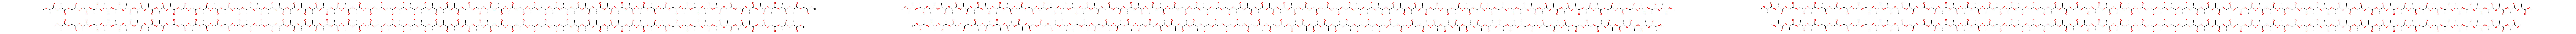

In [32]:
Chem.Draw.MolsToGridImage(x.chain_rdkit, subImgSize=(10000, 200))

In [33]:
Chem.Draw.MolToFile(x.chain_rdkit[0], 'example_chain.png', size=(10000, 300))

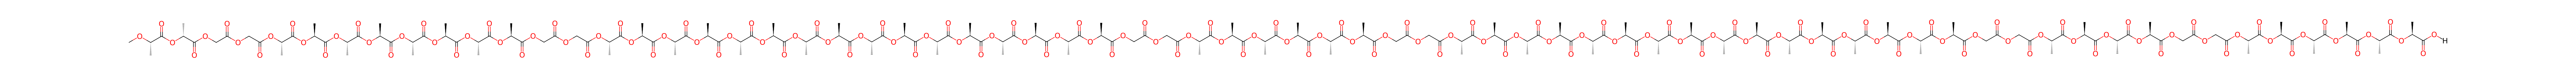

In [34]:
Chem.Draw.MolToImage(x.chain_rdkit[0], size=(10000, 300))

In [35]:
alternating = 'LLGG'*25
print(alternating)
blockiness_calc(alternating)

LLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGGLLGG


(1.0416666666666667, 2, 2)

In [36]:
blocky = 'LL'*25 + 'GG' *12 + 'LL' *25
print(blocky)
blockiness_calc(blocky)

LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLGGGGGGGGGGGGGGGGGGGGGGGGLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL


(12.0, 24, 50)

## Resomer® LG 756 S

In [38]:
#Create a system
start = time.process_time()
x = PLGA_system(75, 1200, 1.7, 'ester', 1)
end = time.process_time()
print('Actual lactide conc. = ', round(x.lactide_actual,2))
print('length = ', x.min_length)
print("Polydispersity Index = ", round(x.PDI,3))
print("Average chain blockiness =", x.mean_blockiness)
print("Average Molecular Weight =", x.mol_weight_average)
print("G Block length =", x.G_block_length)
print("L Block length =", x.L_block_length)
time_elapsed = end - start
print('Build time -', time_elapsed)

System built!, size = 1
Actual lactide conc. =  73.33
length =  1200
Polydispersity Index =  1.0
Average chain blockiness = 1.6666666666666667
Average Molecular Weight = 81972.37
G Block length = 3.3333333333333335
L Block length = 9.166666666666666
Build time - 62.90364699999998


## Benchmarking

In [ ]:
import pandas as pd
df_length = pd.DataFrame()
te_length = []
#Create a system
for length in range (50, 1000):
    start = time.process_time()
    PLGA_system(75, length, 1.7, 'hydroxyl', 1)
    end = time.process_time()
    time_elapsed = end - start
    te_length.append(time_elapsed)
df_length['Length'] = range(50, 1000)
df_length['Time_elapsed'] = te_length
    
df_length.to_csv('Length_benchmark_75.csv')

In [44]:
import seaborn as sns
#Colour blind friendly colour wheel
cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']
cb_wheel = sns.color_palette(palette=cb_color_cycle)    
sns.set_context('talk')
sns.set_palette(cb_wheel)

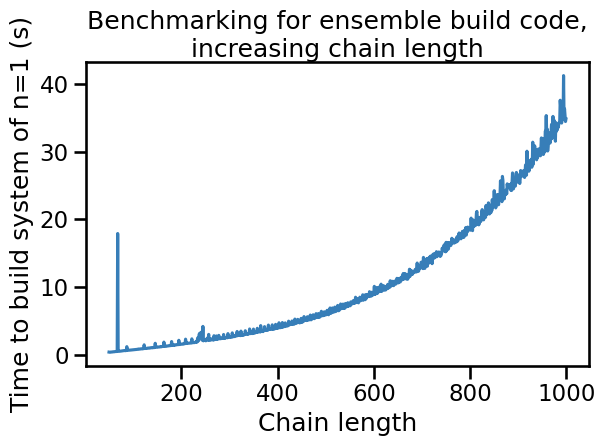

In [46]:
#Plot results and export
sns.lineplot(x = df_length['Length'], y=df_length['Time_elapsed'], palette='#ff7f00')
plt.xlabel('Chain length')
plt.ylabel('Time to build system of n=1 (s)')
plt.title('Benchmarking for ensemble build code, increasing chain length', size=18, wrap=True)
plt.tight_layout()
plt.savefig('length_1000_plot_75')

In [ ]:
df_size = pd.DataFrame()
#te_size = []

#Create a system
for size in range (165,250):
    start = time.process_time()
    PLGA_system(75, 50, 1.7, 'hydroxyl', size)
    end = time.process_time()
    time_elapsed = end - start
    te_size.append(time_elapsed)
df_size['size'] = range(10,250)
df_size['Time_elapsed'] = te_size
    
df_size.to_csv('size_benchmark_75.csv')

System built!, size = 165
System built!, size = 166
System built!, size = 167
System built!, size = 168
System built!, size = 169
System built!, size = 170
System built!, size = 171
System built!, size = 172
System built!, size = 173
System built!, size = 174
System built!, size = 175
System built!, size = 176
System built!, size = 177
System built!, size = 178
System built!, size = 179
System built!, size = 180
System built!, size = 181
System built!, size = 182
System built!, size = 183
System built!, size = 184
System built!, size = 185
System built!, size = 186
System built!, size = 187
System built!, size = 188
System built!, size = 189
System built!, size = 190
System built!, size = 191
System built!, size = 192
System built!, size = 193
System built!, size = 194
System built!, size = 195
System built!, size = 196
System built!, size = 197
System built!, size = 198
System built!, size = 199
System built!, size = 200
System built!, size = 201
System built!, size = 202
System built

In [ ]:
sns.set_context('poster')
fig, axs = plt.subplots(1, figsize=(7.5, 5))
sns.lineplot(x = df_size['size'], y=df_size['Time_elapsed'], c='g', ax=axs)
plt.xlabel('System size', wrap=True, size=18)
plt.ylabel('Time to build system (s)', wrap=True, size=18)
plt.title('Ensemble Build Speed Benchmarking', size=18, wrap=True)
plt.tight_layout()
plt.show()
fig.savefig('size_250_plot_75', dpi=500)